# Проект: Определение стоимости автомобилей

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Категоризация-данных" data-toc-modified-id="Категоризация-данных-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Категоризация данных</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

**Описание проекта**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» (Название вымышленное), разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В моём распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Мне нужно построить модель машинного обучения для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных**

Файл с данными: `autos.csv`.

Признаки:
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `NotRepaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

Целевой признак: `Price` — цена (евро)

## Подготовка данных

### Импорт библиотек

Импортируем необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import time

### Загрузка данных

Загрузим данные и посмотрим на них:

In [2]:
df = pd.read_csv('/datasets/autos.csv')
print()
print('Data:')
display(df)
print('---------------------------------------------')
print()
print('Info:')
print(df.info())
print('---------------------------------------------')
print()
print('Shape:')
print(df.shape)
print('---------------------------------------------')
print()
print('Sample:')
display(df.sample(10, random_state=555))
print('---------------------------------------------')
print()
print('Correlation:')
display(df.corr())
print('---------------------------------------------')
print()
print("NaN's:")
print(df.isna().sum())


Data:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


---------------------------------------------

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB
None
---------------------------------------------

Shape:
(354369, 16)
----------------

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
287377,2016-03-28 12:38:57,16900,sedan,2010,auto,170,a6,100000,2,gasoline,audi,no,2016-03-28 00:00:00,0,10627,2016-04-06 15:15:37
82477,2016-03-26 16:48:43,3350,wagon,1999,manual,193,3er,150000,10,petrol,bmw,no,2016-03-26 00:00:00,0,31515,2016-04-04 04:18:21
60773,2016-04-02 14:38:21,1600,wagon,2000,manual,0,polo,125000,1,petrol,volkswagen,no,2016-04-02 00:00:00,0,37081,2016-04-06 12:46:01
217488,2016-03-16 11:57:30,3000,sedan,2006,NaN,82,a_klasse,150000,3,gasoline,mercedes_benz,no,2016-03-16 00:00:00,0,38642,2016-03-16 11:57:30
11297,2016-03-15 14:52:36,14850,bus,2014,manual,140,zafira,40000,3,NaN,opel,no,2016-03-10 00:00:00,0,83471,2016-04-07 07:44:47
304803,2016-03-27 16:57:52,1250,small,2005,manual,60,ka,100000,6,petrol,ford,NaN,2016-03-27 00:00:00,0,61203,2016-03-27 17:42:14
217476,2016-03-13 21:48:14,19000,sedan,2011,auto,170,golf,80000,5,gasoline,volkswagen,no,2016-03-13 00:00:00,0,50858,2016-04-06 19:16:59
187770,2016-04-01 19:48:31,5500,small,2010,manual,80,fusion,10000,10,petrol,ford,no,2016-04-01 00:00:00,0,56642,2016-04-01 19:48:31
57096,2016-03-20 21:37:23,1050,small,1999,manual,0,twingo,150000,0,petrol,renault,no,2016-03-20 00:00:00,0,27804,2016-03-24 16:15:49
168828,2016-03-25 21:56:34,200,small,1997,manual,50,fiesta,150000,5,petrol,ford,NaN,2016-03-25 00:00:00,0,49497,2016-03-27 11:17:56


---------------------------------------------

Correlation:


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


---------------------------------------------

NaN's:
DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


На первый взгляд видно:
- есть пропуски в некоторых признаках;
- достаточно много колонок типа объект. Вероятно какие-то из них можно будет удалить (например с датами), а какие-то разбить по категориям и преобразовать в числовой;
- сильной корреляции между признаками не наблюдается. После категоризации признаков надо будет ещё раз проверить;
- в колонке с количеством изображений возможно везде нули и она нам не пригодится;
- из косметического: перевести названия колонок в нижний регистр.

### Предобработка данных

Начнём с названия колонок, для дальнейшей простоты работы.

In [3]:
df.columns = df.columns.str.lower()
df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'notrepaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

Далее колонка изображений. Посмотрим есть ли там ещё какие-либо значения кроме нулей:

In [4]:
df['numberofpictures'].value_counts()

0    354369
Name: numberofpictures, dtype: int64

Нет. Значит, смысловой нагрузки в данном случае она нам никакой не несёт.

In [5]:
df.drop(['numberofpictures'], axis=1, inplace=True)

Теперь посмотрим на колонки с датами:

In [6]:
df[['datecrawled', 'datecreated']].sample(10)

,datecrawled,datecreated
116639,2016-03-21 15:45:15,2016-03-21 00:00:00
135479,2016-03-21 17:39:53,2016-03-21 00:00:00
144518,2016-03-23 13:52:15,2016-03-23 00:00:00
45809,2016-03-16 19:36:27,2016-03-16 00:00:00
113799,2016-03-10 16:53:57,2016-03-10 00:00:00
151257,2016-03-22 15:42:14,2016-03-22 00:00:00
56170,2016-03-06 12:52:14,2016-03-06 00:00:00
312731,2016-03-29 12:50:07,2016-03-29 00:00:00
146533,2016-03-21 09:36:33,2016-03-21 00:00:00
269839,2016-03-26 13:45:23,2016-03-26 00:00:00


Видно что, даты в объявлениях совпадают. Различие только во времени. Одну из колонок можно удалить, а по-поводу второй есть такая мысль: Тут получается, что все объявления размещались в 2016-м году. Мы можем перевести колонку в формат даты и разбить их на месяца, так как возможно в разные месяца машины продаются по разному и эта информация может пригодиться в обучении и предсказаниях.

Удаляем одну колонку:

In [7]:
df.drop(['datecrawled'], axis=1, inplace=True)

Вторую переводим в формат времени:

In [8]:
df['datecreated'] = pd.to_datetime(
    df['datecreated'], format='%Y-%m-%d %H:%M:%S')
df['datecreated'] = pd.DatetimeIndex(df['datecreated']).month
df = df.rename(columns={'datecreated':'monthcreated'})
df

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,monthcreated,postalcode,lastseen
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,3,70435,2016-04-07 03:16:57
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,3,66954,2016-04-07 01:46:50
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,3,90480,2016-04-05 12:47:46
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,3,91074,2016-03-17 17:40:17
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,3,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,3,2694,2016-03-21 10:42:49
354365,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,3,39576,2016-04-06 00:46:52
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,3,26135,2016-03-11 18:17:12
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,3,87439,2016-04-07 07:15:26


Получилась колонка с месяцем создания объявления.

Теперь посмотрим на колонки с данными типа объект.\
Начнём с колонки тип кузова:

In [9]:
df['vehicletype'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicletype, dtype: int64

Эту колонку можно категоризировать.

Теперь колонка с коробками передач:

In [10]:
df['gearbox'].value_counts()

manual    268251
auto       66285
Name: gearbox, dtype: int64

Тоже можно категоризировать.

Далее модель авто:

In [11]:
df['model'].value_counts()

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
rangerover                4
serie_3                   4
serie_1                   2
range_rover_evoque        2
Name: model, Length: 250, dtype: int64

Думаю, тут тоже можно категоризировать, только пока смущает 250 наименований.

Продолжим, тип топлива:

In [12]:
df['fueltype'].value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fueltype, dtype: int64

Тоже хорошие категории получатся.

Колонка марки авто:

In [13]:
df['brand'].value_counts()

volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2323
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: brand, dtype: int64

И тут вполне бъётся по категориям, только тоже многовато разновидностей.

Теперь колонка ремонта:

In [14]:
df['notrepaired'].value_counts()

no     247161
yes     36054
Name: notrepaired, dtype: int64

Можно категоризировать.

И наконец колонка с датой последнего визита. Тут бить по категориям точно не получится, если только что-то вроде: давно был продавец на сайте или нет. Но тут может быль такое, что продавец в начале года продал машину и больше сервисом не пользуется. То есть информация, что его давно нет на сайте по-сути ничего не даёт. Так что, я думаю эта колонка особой пользы не принесёт.

In [15]:
df.drop(['lastseen'], axis=1, inplace=True)

В итоге будем пробовать категоризировать все объектовые колонки.

Ещё есть вероятность наличия выбросов в колонке с годами выпуска авто:

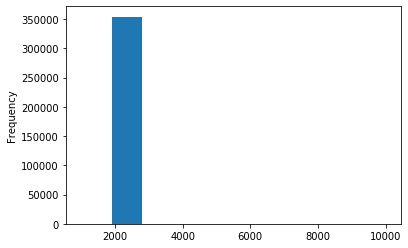

In [16]:
df['registrationyear'].plot(kind='hist')

In [17]:
df['registrationyear'].describe()

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registrationyear, dtype: float64

Думаю, тут надо убирать все значения выше 2016-го года, так как если объявления размещались в 2016-м году, то более новых машин на тот момент не могло существовать. И убирать значения ниже 1980-го, так как это менее одного процента от всех данных:

In [18]:
round(len(df[df['registrationyear'] < 1980]) / len(df) * 100)

1

Убираем выбросы и посмотрим на распределение:

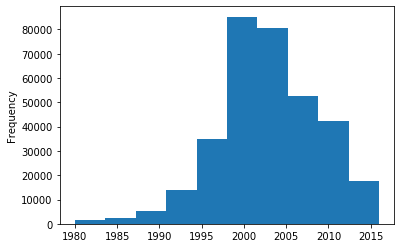

In [19]:
df.drop(df[df['registrationyear'] > 2016].index, inplace=True)
df.drop(df[df['registrationyear'] < 1980].index, inplace=True)
df['registrationyear'].plot(kind='hist')

Теперь распределение по годам более нормальное.

Посмотрим на распределение по месяцам выпуска:

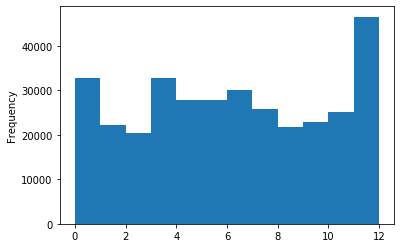

In [20]:
df['registrationmonth'].plot(kind='hist', bins=12)

По месяцам, выбросов нет, тут всё нормально.

Теперь проверим колонку с мощностью двигателя:

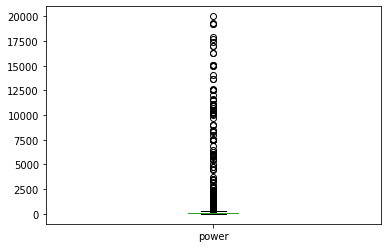

In [21]:
df['power'].plot(kind='box')

In [22]:
df['power'].describe()

count    336387.000000
mean        111.366973
std         185.510237
min           0.000000
25%          70.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

Тут тоже имеем выбросы, как в сторону низкой, так и в сторону высокой мощности. Можно взять автомобили с мощностью от 50 л.с. до 500. Думаю, выше там только "Формула-1".

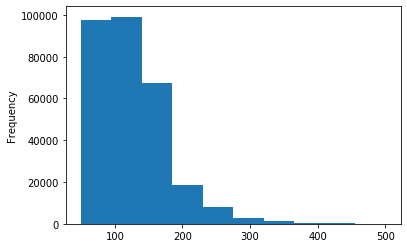

In [23]:
df.drop(df[df['power'] > 500].index, inplace=True)
df.drop(df[df['power'] < 50].index, inplace=True)
df['power'].plot(kind='hist')

Теперь выглядит намного лучше. С высокой мощностью от 300-а л.с. машин тоже немного, но такие варианты впринципе можно допустить.

In [24]:
df[df['power'] > 300].sample(15)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,monthcreated,postalcode
334319,17500,convertible,2003,auto,306,sl,100000,3,petrol,mercedes_benz,no,3,61389
300559,0,sedan,2007,auto,306,3er,125000,10,petrol,bmw,no,4,47053
104557,4999,sedan,1995,auto,326,7er,150000,1,petrol,bmw,NaN,3,78056
96337,18900,NaN,2006,auto,330,mustang,125000,1,petrol,ford,no,3,47877
340569,9599,coupe,2003,auto,306,cl,150000,3,lpg,mercedes_benz,no,4,78564
341871,5999,suv,2004,auto,313,touareg,125000,9,gasoline,volkswagen,yes,3,58730
193672,10999,sedan,2007,auto,326,a8,150000,7,gasoline,audi,NaN,4,46562
330618,9999,sedan,2002,auto,354,c_klasse,150000,3,petrol,mercedes_benz,no,3,3044
261004,14950,sedan,2005,auto,445,7er,150000,4,petrol,bmw,no,3,95032
198117,19590,coupe,2006,auto,367,6er,150000,3,petrol,bmw,no,3,38440


Похоже на правду, судя по машинам.

Теперь посмотрим на колонку с ценами:

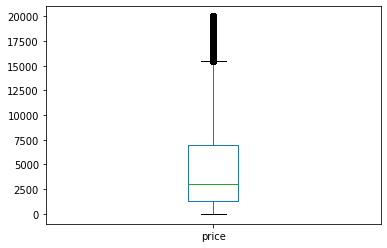

In [25]:
df['price'].plot(kind='box')

In [26]:
df['price'].describe()

count    295416.000000
mean       4785.677289
std        4610.185556
min           0.000000
25%        1299.000000
50%        3057.500000
75%        6950.000000
max       20000.000000
Name: price, dtype: float64

И тут тоже присутствуют выбросы в виде нулевых значений и довольно высоких. Думаю, цены ниже 500 евро вряд-ли можно считать релевантными, так как ниже будут совсем старые и "убитые" авто, а так как наш сервис: "Не бит, не крашен", то такая категория вряд ли подойдёт. Заодно отметём нулевые значения. С высокими значениями сложнее, так как авто могут быть премиальные и ценник у них соответствующий. Попробуем их оставить.

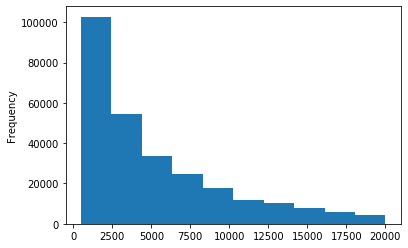

In [27]:
df.drop(df[df['price'] < 500].index, inplace=True)
df['price'].plot(kind='hist')

Вышло неплохое одностороннее распределение.

Взглянем на колонку с пробегом:

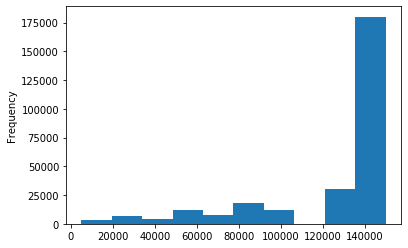

In [28]:
df['kilometer'].plot(kind='hist')

Впринципе, аномалий я тут не вижу, все значения в пределах нормы.

У нас осталась ещё колонка с индексами. По сути, это тоже категории, так как индексом обозначаются регионы. Можно сократить их до двухзначных чисел, которые будут обозначать регион. Тогда моделям будет проще работать с такими данными.

In [29]:
df['postalcode'] = round(df['postalcode'] / 1000).astype('int')
df = df.rename(columns={'postalcode':'region'})

In [30]:
df.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,monthcreated,region
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,3,67
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,3,90
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,3,91
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,3,60
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,4,34


Получили около ста признаков вместо нескольких тысяч.

Теперь посмотрим ещё раз на пропуски:

In [31]:
df.isna().sum()

price                    0
vehicletype           8259
registrationyear         0
gearbox               4161
power                    0
model                 8998
kilometer                0
registrationmonth        0
fueltype             12306
brand                    0
notrepaired          35696
monthcreated             0
region                   0
dtype: int64

Пойдём по более быстрому пути и удалим все строки с пропусками:

In [32]:
df.dropna(inplace=True)
df.isna().sum()

price                0
vehicletype          0
registrationyear     0
gearbox              0
power                0
model                0
kilometer            0
registrationmonth    0
fueltype             0
brand                0
notrepaired          0
monthcreated         0
region               0
dtype: int64

In [33]:
print(df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221484 entries, 3 to 354367
Data columns (total 13 columns):
price                221484 non-null int64
vehicletype          221484 non-null object
registrationyear     221484 non-null int64
gearbox              221484 non-null object
power                221484 non-null int64
model                221484 non-null object
kilometer            221484 non-null int64
registrationmonth    221484 non-null int64
fueltype             221484 non-null object
brand                221484 non-null object
notrepaired          221484 non-null object
monthcreated         221484 non-null int64
region               221484 non-null int64
dtypes: int64(7), object(6)
memory usage: 23.7+ MB
None
(221484, 13)


Понесли потери, но теперь пропусков в данных нет, от выбросов тоже избавились. Можно переходить к категоризации.

### Категоризация данных

Для перевода категориальных признаков в числовые, воспользуемся библиотекой Ordinal Encoder, потому что, если мы воспользуемся методом ОНЕ, то наш датасет сильно "расрастётся" из-за призаков с большим количеством категорий.

Произведём трансформацию:

In [34]:
cathegorial = ['vehicletype', 'gearbox', 'model',
               'fueltype', 'brand', 'notrepaired']
encoder = OrdinalEncoder()
df_cathegorial = pd.DataFrame(
    encoder.fit_transform(df[cathegorial]),
    index=df[cathegorial].index,
    columns=df[cathegorial].columns
)
df_cathegorial.head()

,vehicletype,gearbox,model,fueltype,brand,notrepaired
3,5.0,1.0,116.0,6.0,37.0,0.0
4,5.0,1.0,101.0,2.0,31.0,0.0
5,4.0,1.0,11.0,6.0,2.0,1.0
6,1.0,1.0,8.0,6.0,25.0,0.0
10,4.0,1.0,10.0,6.0,19.0,0.0


Преобразовали категориальные данные в числовые. Теперь объединим их с основной таблицей:

In [35]:
df[cathegorial] = df_cathegorial
df.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,monthcreated,region
3,1500,5.0,2001,1.0,75,116.0,150000,6,6.0,37.0,0.0,3,91
4,3600,5.0,2008,1.0,69,101.0,90000,7,2.0,31.0,0.0,3,60
5,650,4.0,1995,1.0,102,11.0,150000,10,6.0,2.0,1.0,4,34
6,2200,1.0,2004,1.0,109,8.0,150000,8,6.0,25.0,0.0,4,67
10,2000,4.0,2004,1.0,105,10.0,150000,12,6.0,19.0,0.0,3,96


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221484 entries, 3 to 354367
Data columns (total 13 columns):
price                221484 non-null int64
vehicletype          221484 non-null float64
registrationyear     221484 non-null int64
gearbox              221484 non-null float64
power                221484 non-null int64
model                221484 non-null float64
kilometer            221484 non-null int64
registrationmonth    221484 non-null int64
fueltype             221484 non-null float64
brand                221484 non-null float64
notrepaired          221484 non-null float64
monthcreated         221484 non-null int64
region               221484 non-null int64
dtypes: float64(6), int64(7)
memory usage: 23.7 MB


Готово. Теперь ещё раз проверим корреляцию между признаками:

In [37]:
df.corr()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,monthcreated,region
price,1.000000,-0.071321,0.630418,-0.247194,0.495303,-0.012962,-0.413505,0.028537,-0.270604,-0.104458,-0.185994,0.014771,0.052729
vehicletype,-0.071321,1.000000,0.051295,-0.044906,-0.014272,-0.157854,0.041106,0.020641,-0.057703,-0.057732,0.014188,-0.007738,-0.018332
registrationyear,0.630418,0.051295,1.000000,-0.038503,0.106206,0.009410,-0.455771,0.010807,-0.273318,-0.002597,-0.101242,-0.000111,0.024817
gearbox,-0.247194,-0.044906,-0.038503,1.000000,-0.438001,0.042126,-0.035632,-0.020448,0.140050,0.111356,0.006110,-0.002370,0.043576
power,0.495303,-0.014272,0.106206,-0.438001,1.000000,-0.126544,0.127532,0.022544,-0.189554,-0.326937,-0.020360,0.002638,0.043815
model,-0.012962,-0.157854,0.009410,0.042126,-0.126544,1.000000,-0.040531,-0.002922,-0.038983,0.475940,0.003199,-0.003550,-0.047023
kilometer,-0.413505,0.041106,-0.455771,-0.035632,0.127532,-0.040531,1.000000,-0.004675,-0.180565,-0.061597,0.083286,-0.001693,-0.009312
registrationmonth,0.028537,0.020641,0.010807,-0.020448,0.022544,-0.002922,-0.004675,1.000000,-0.045549,-0.005009,-0.024096,-0.004267,-0.000845
fueltype,-0.270604,-0.057703,-0.273318,0.140050,-0.189554,-0.038983,-0.180565,-0.045549,1.000000,0.032344,0.006954,0.006705,-0.005205
brand,-0.104458,-0.057732,-0.002597,0.111356,-0.326937,0.475940,-0.061597,-0.005009,0.032344,1.000000,-0.009172,0.000688,-0.058835


В итоге сильно коррелирующих признаков не появилось. Есть некоторая корреляция цены с годом выпуска(что весьма логично), мощностью и ценой(что тоже логично) и брендом с моделью(не слишком высокая).

Теперь можно переходить к работе с моделями.

## Обучение моделей

Сперва разделим данные на обучающую валидационную и тестовую выборки в соотношении 60/20/20:

In [38]:
features = df.drop(['price'], axis=1)
target = df['price']
features_train, features, target_train, target = train_test_split(features, target, test_size=.4)
features_valid, features_test, target_valid, target_test = train_test_split(features, target, test_size=.5)

print('features', features_train.shape, features_valid.shape, features_test.shape, sep='|')
print('targets', target_train.shape, target_valid.shape, target_test.shape, sep=' |  ')
print('ratio', round(len(features_train) / len(df) * 100),
      round(len(features_valid) / len(df) * 100),
      round(len(features_test) / len(df) * 100), sep='   |      ')

features|(132890, 12)|(44297, 12)|(44297, 12)
targets |  (132890,) |  (44297,) |  (44297,)
ratio   |      60   |      20   |      20


Разделение прошло успешно.

Обучим разные модели. Возьмём модели: Решающее дерево, Случайный лес и модель градиентного бустинга LightGBM. Оценивать модели будем по метрике RMSE. У каждой модели будим измерять время обучения.

Создадим функцию, которая будет брать модель, обучать и сохранять лучшие результаты:

In [39]:
def fit_and_check(model, features_train, target_train,
                  features_valid, target_valid):
    global best_model
    global best_result
    clf = model
    clf.fit(features_train, target_train)
    predictions = clf.predict(features_valid)
    result = (mean_squared_error(target_valid, predictions)) ** .5
    if result < best_result:
        best_result = round(result, 2)
        best_model = model

Произведём обучение моделей и подбор лучших параметров, и сохраним результаты.

Сначала модель Решающее дерево:

In [40]:
best_model = 0
best_result = 10000
t_start = time.time()

for depth in range(1, 15):
    fit_and_check(
        DecisionTreeRegressor(max_depth=depth, random_state=555),
        features_train, target_train, features_valid, target_valid)
    
t_stop = time.time()
execution_time = round(t_stop - t_start, 2)

best_tree_model, best_tree_result, best_tree_time = best_model, best_result, execution_time

print(best_tree_model)

DecisionTreeRegressor(criterion='mse', max_depth=13, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=555, splitter='best')


Далее модель Случайный лес:

In [41]:
best_model = 0
best_result = 10000
t_start = time.time()

for est in range(10, 50, 10):
    for depth in range(1, 15):
        fit_and_check(
            RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=555),
            features_train, target_train, features_valid, target_valid)
        
t_stop = time.time()
execution_time = round(t_stop - t_start, 2)

best_forest_model, best_forest_result, best_forest_time = best_model, best_result, execution_time

print(best_forest_model)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=14,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=40,
                      n_jobs=None, oob_score=False, random_state=555, verbose=0,
                      warm_start=False)


И модель LightGBM:

In [42]:
train_data = lgb.Dataset(features_train, target_train)
validation_data = lgb.Dataset(features_valid, target_valid)
params_lgb = {'objective': 'regression', 'metric': 'root_mean_squared_error'}

t_start = time.time()
lgb_tree_model = lgb.train(params_lgb, train_data, num_boost_round=200, valid_sets=(validation_data))
lgb_tree_predictions = lgb_tree_model.predict(features_valid)
t_stop = time.time()

lgb_tree_result = round((mean_squared_error(target_valid, lgb_tree_predictions) ** .5), 2)
lgb_tree_time = round(t_stop - t_start, 2)

[1]	valid_0's rmse: 4351.91
[2]	valid_0's rmse: 4043.2
[3]	valid_0's rmse: 3772.68
[4]	valid_0's rmse: 3532.96
[5]	valid_0's rmse: 3325.56
[6]	valid_0's rmse: 3141.91
[7]	valid_0's rmse: 2982.37
[8]	valid_0's rmse: 2843.31
[9]	valid_0's rmse: 2719.97
[10]	valid_0's rmse: 2613.66
[11]	valid_0's rmse: 2517.86
[12]	valid_0's rmse: 2433.15
[13]	valid_0's rmse: 2362.56
[14]	valid_0's rmse: 2294.87
[15]	valid_0's rmse: 2239.68
[16]	valid_0's rmse: 2190.22
[17]	valid_0's rmse: 2145.67
[18]	valid_0's rmse: 2106.06
[19]	valid_0's rmse: 2070.88
[20]	valid_0's rmse: 2039.85
[21]	valid_0's rmse: 2012.66
[22]	valid_0's rmse: 1985.8
[23]	valid_0's rmse: 1963.6
[24]	valid_0's rmse: 1936.19
[25]	valid_0's rmse: 1914.41
[26]	valid_0's rmse: 1895.5
[27]	valid_0's rmse: 1875.09
[28]	valid_0's rmse: 1858.49
[29]	valid_0's rmse: 1844.43
[30]	valid_0's rmse: 1831.76
[31]	valid_0's rmse: 1821.39
[32]	valid_0's rmse: 1807.38
[33]	valid_0's rmse: 1795.47
[34]	valid_0's rmse: 1786.98
[35]	valid_0's rmse: 1777.4

Посмотрим на результаты обучения:

In [43]:
train_model_results = {'RMSE score': [best_tree_result, best_forest_result, lgb_tree_result],
                 'Prediction time(sec)': [best_tree_time, best_forest_time, lgb_tree_time]}

In [44]:
train_results = pd.DataFrame(data=train_model_results, index=('Model Tree:', 'Model Forest:', 'Model LightGBM:'))
train_results

,RMSE score,Prediction time(sec)
Model Tree:,1849.18,5.42
Model Forest:,1594.00,331.15
Model LightGBM:,1548.82,551.84


Самая лучшая модель по результатам обучения получилась модель LightGBM. У остальных моделей результаты хуже. Модель Случайный лес при этом близка по результатам, но намного дольше всех обучалась.

## Анализ моделей

Теперь проверим лучшие получившиеся модели на тестовой выборке и сравним их результаты и их время предсказаний.

Создадим функцию для теста, подсчёта результатов и времени предсказаний:

In [45]:
def test_model(model, features_test, target_test):
    t_start = time.time()
    predictions = model.predict(features_test)
    t_stop = time.time()
    execution_time = round(t_stop - t_start, 2)
    result = round((mean_squared_error(target_test, predictions) ** .5), 2)
    return result, execution_time

Проведём тест:

In [46]:
test_tree_result, test_tree_time = test_model(best_tree_model, features_test, target_test)
test_forest_result, test_forest_time = test_model(best_forest_model, features_test, target_test)
test_lgb_result, test_lgb_time = test_model(lgb_tree_model, features_test, target_test)

Посмотрим на результаты:

In [47]:
test_model_results = {'RMSE score': [test_tree_result, test_forest_result, test_lgb_result],
                      'Predictions time(sec)': [test_tree_time, test_forest_time, test_lgb_time]}

In [48]:
test_results = pd.DataFrame(data=test_model_results, index=('Model Tree:', 'Model Forest:', 'Model LightGBM:'))
test_results

,RMSE score,Predictions time(sec)
Model Tree:,1878.32,0.01
Model Forest:,1612.44,0.39
Model LightGBM:,1562.71,1.01


По качеству предсказаний, побеждает снова модель LightGBM. Однако в этот раз она проиграла остальным моделям в скорости предсказаний. При этом модель Случайный лес практически сравнялась с ней по результатам и значительно обогнала по скорости предсказания.

Наконец, посмотрим какие признаки были наиболее важными при построении модели. Возьмём модель Случайный лес так как она была хороша по результатам и скорости предсказания.

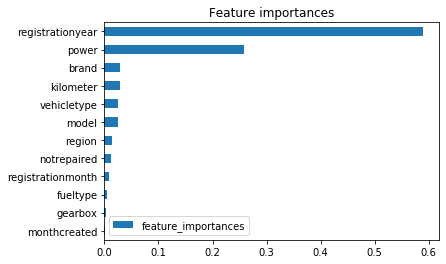

In [49]:
feature_importances = pd.DataFrame(
    best_forest_model.feature_importances_, index=features.columns, columns=['feature_importances'])
feature_importances.sort_values(by=['feature_importances']).plot(kind='barh', title='Feature importances')

Получилось, что наиболее важными признаками оказались год автомобиля и мощность. Кстати, эти признаки имели довольно высокую корреляцию с ценой. Далее остальные признаки почти равны. И самым "бесполезным" оказался признак с месяцем создания объявления, видимо сезон продажи на цену не влияет.

## Вывод

В итоге получилось, что модель градиентного бустинга LightGBM предсказывает лучше чем "классические" модели. Однако скорость обучения и предсказания не самые быстрые.

Я думаю, тут стоит решить что важнее, скорость или качество. Если важнее качество, то безусловно модель градиентного бустинга отлично подойдёт. Если важнее скорость обучения и предсказания, то стоит обратить внимание на более быстрые модели, например Решающее дерево. И если важнее всего скорость и качество предсказания, то отлично подойдёт модель Случайный лес.